In [6]:
from torch import nn
# 实现：可配置残差连接的 ResNet18（用于消融实验）
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader

# ------------------------- 可配置残差连接的基本Block -------------------------
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, use_residual=True):
        super(BasicBlock, self).__init__()
        self.use_residual = use_residual

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.use_residual:
            out += self.shortcut(x)
        out = F.relu(out)
        return out

# ------------------------- 自定义 ResNet 架构 -------------------------
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, use_residual=True):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.use_residual = use_residual

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.use_residual))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes=10, use_residual=True):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, use_residual=use_residual)

# ------------------------- CIFAR-10 数据预处理 -------------------------
def get_loaders(batch_size=128):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    return trainloader, testloader

# ------------------------- 训练与测试流程 + 日志与绘图 -------------------------
def train_and_evaluate(model, trainloader, testloader, epochs=30, lr=0.1, device='cuda', log_dir='logs'):
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    os.makedirs(log_dir, exist_ok=True)
    train_acc_list, test_acc_list = [], []
    log_file = os.path.join(log_dir, f'{model.__class__.__name__}_residual_{getattr(model, "use_residual", True)}.log')

    with open(log_file, 'w') as f:
        for epoch in range(epochs):
            model.train()
            correct, total, total_loss = 0, 0, 0.0
            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
            scheduler.step()

            train_acc = 100. * correct / total
            test_acc = evaluate(model, testloader, device)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)

            f.write(f"Epoch {epoch+1}: Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%\n")
            print(f"Epoch {epoch+1}: Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

    # 保存曲线图
    plt.figure()
    plt.plot(train_acc_list, label='Train Acc')
    plt.plot(test_acc_list, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training/Test Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(log_dir, f'{model.__class__.__name__}_residual_{getattr(model, "use_residual", True)}.png'))
    plt.close()

# ------------------------- 测试函数 -------------------------
def evaluate(model, dataloader, device='cuda'):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100. * correct / total

# ------------------------- 主入口 -------------------------
if __name__ == '__main__':
    trainloader, testloader = get_loaders()
    
    # 实验组1：正常残差连接
    model_res = ResNet18(use_residual=True)
    train_and_evaluate(model_res, trainloader, testloader, epochs=30, device='cuda', log_dir='logs')

    # 实验组2：去除残差连接
    model_nores = ResNet18(use_residual=False)
    train_and_evaluate(model_nores, trainloader, testloader, epochs=30, device='cuda', log_dir='logs')

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train Acc: 29.81%, Test Acc: 38.68%
Epoch 2: Train Acc: 45.41%, Test Acc: 52.49%
Epoch 3: Train Acc: 56.53%, Test Acc: 60.80%
Epoch 4: Train Acc: 64.80%, Test Acc: 65.25%
Epoch 5: Train Acc: 69.95%, Test Acc: 71.18%
Epoch 6: Train Acc: 74.55%, Test Acc: 76.00%
Epoch 7: Train Acc: 77.70%, Test Acc: 76.84%
Epoch 8: Train Acc: 79.60%, Test Acc: 76.09%
Epoch 9: Train Acc: 80.94%, Test Acc: 76.09%
Epoch 10: Train Acc: 81.58%, Test Acc: 79.76%
Epoch 11: Train Acc: 82.59%, Test Acc: 75.57%
Epoch 12: Train Acc: 83.00%, Test Acc: 77.60%
Epoch 13: Train Acc: 83.50%, Test Acc: 73.96%
Epoch 14: Train Acc: 83.88%, Test Acc: 77.35%
Epoch 15: Train Acc: 84.40%, Test Acc: 81.83%
Epoch 16: Train Acc: 90.51%, Test Acc: 89.57%
Epoch 17: Train Acc: 92.16%, Test Acc: 90.19%
Epoch 18: Train Acc: 92.82%, Test Acc: 90.38%
Epoch 19: Train Acc: 93.40%, Test Acc: 90.82%
Epoch 20: Train Acc: 93.97%, Test Acc: 91.01%
Epoch 21: Tra

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from thop import profile
import time
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
log_file = 'ablation_results.log'

# ===================== 写入日志函数 =====================
def write_log(content, end='\n'):
    with open(log_file, 'a') as f:
        f.write(content + end)
    print(content, end=end)

# ===================== 数据加载 =====================
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)
testloader = DataLoader(testset, batch_size=16, shuffle=False)

# ===================== 模型定义 =====================
class CNNBaseline(nn.Module):
    def __init__(self, use_bn=True, use_pool=True):
        super(CNNBaseline, self).__init__()
        self.use_bn = use_bn
        self.use_pool = use_pool
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) if use_bn else nn.Identity()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) if use_bn else nn.Identity()
        self.pool = nn.MaxPool2d(2, 2) if use_pool else nn.Identity()

        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 32, 32)
            x = self.pool(F.relu(self.bn1(self.conv1(dummy_input))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            flattened_dim = x.view(1, -1).size(1)

        self.fc = nn.Linear(flattened_dim, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        return self.fc(x)

# ===================== 训练 + 测试函数 =====================
def train_and_evaluate(model, model_name="Model", epochs=50):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    correct_train = total_train = 0
    model.train()
    start_train = time.time()

    for epoch in range(epochs):
        running_loss = 0.0
        correct_epoch = total_epoch = 0
        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_epoch += targets.size(0)
            correct_epoch += predicted.eq(targets).sum().item()

        acc_epoch = 100. * correct_epoch / total_epoch
        line = f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(trainloader):.4f} | Acc: {acc_epoch:.2f}%"
        write_log(line)

        correct_train += correct_epoch
        total_train += total_epoch

    train_time = time.time() - start_train
    train_acc = 100. * correct_train / total_train

    # 测试阶段
    model.eval()
    correct_test = total_test = 0
    start_test = time.time()
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total_test += targets.size(0)
            correct_test += predicted.eq(targets).sum().item()
    test_time = time.time() - start_test
    test_acc = 100. * correct_test / total_test

    # FLOPs, Params, Size
    dummy_input = torch.randn(1, 3, 32, 32).to(device)
    flops, params = profile(model, inputs=(dummy_input,), verbose=False)
    model_size_mb = sum(p.numel() for p in model.parameters()) * 4 / (1024 ** 2)

    # 写入指标
    write_log("\n--- Evaluation Result for: " + model_name + " ---")
    write_log(f"Final Train Acc: {train_acc:.2f}%")
    write_log(f"Test Acc: {test_acc:.2f}%")
    write_log(f"Train Time: {train_time:.2f}s")
    write_log(f"Test Time: {test_time:.2f}s")
    write_log(f"FLOPs: {flops / 1e6:.2f} MFLOPs")
    write_log(f"Params: {params / 1e6:.2f} M")
    write_log(f"Model Size: {model_size_mb:.2f} MB\n")
    
    return test_acc

# ===================== 执行对比实验 =====================
experiments = [
    {'name': 'Baseline (BN + Pool)', 'use_bn': True, 'use_pool': True},
    {'name': 'No BN', 'use_bn': False, 'use_pool': True},
    {'name': 'No Pool', 'use_bn': True, 'use_pool': False},
    {'name': 'No BN & No Pool', 'use_bn': False, 'use_pool': False},
]

write_log('=== Ablation Study on CIFAR-10 ===\n')

for exp in experiments:
    model_name = exp['name']
    write_log(f"\n### Training: {model_name} ###\n")
    model = CNNBaseline(use_bn=exp['use_bn'], use_pool=exp['use_pool'])
    train_and_evaluate(model, model_name=model_name)


Files already downloaded and verified
Files already downloaded and verified
=== Ablation Study on CIFAR-10 ===


### Training: Baseline (BN + Pool) ###
Epoch 1/50 | Loss: 1.4942 | Acc: 47.35%
Epoch 2/50 | Loss: 1.1662 | Acc: 59.03%
Epoch 3/50 | Loss: 1.0649 | Acc: 62.71%
Epoch 4/50 | Loss: 1.0016 | Acc: 65.23%
Epoch 5/50 | Loss: 0.9522 | Acc: 67.11%
Epoch 6/50 | Loss: 0.9160 | Acc: 68.13%
Epoch 7/50 | Loss: 0.8896 | Acc: 69.34%
Epoch 8/50 | Loss: 0.8665 | Acc: 70.00%
Epoch 9/50 | Loss: 0.8501 | Acc: 70.78%
Epoch 10/50 | Loss: 0.8344 | Acc: 71.09%
Epoch 11/50 | Loss: 0.8208 | Acc: 71.49%
Epoch 12/50 | Loss: 0.8106 | Acc: 72.03%
Epoch 13/50 | Loss: 0.7958 | Acc: 72.59%
Epoch 14/50 | Loss: 0.7833 | Acc: 72.99%
Epoch 15/50 | Loss: 0.7753 | Acc: 73.22%
Epoch 16/50 | Loss: 0.7676 | Acc: 73.57%
Epoch 17/50 | Loss: 0.7596 | Acc: 73.84%
Epoch 18/50 | Loss: 0.7516 | Acc: 74.30%
Epoch 19/50 | Loss: 0.7455 | Acc: 74.24%
Epoch 20/50 | Loss: 0.7389 | Acc: 74.64%
Epoch 21/50 | Loss: 0.7365 | Acc: 74.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import time
import matplotlib.pyplot as plt
from thop import profile

# ---------------------- 数据加载 ----------------------
def get_loaders(batch_size=16):
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    return trainloader, testloader

# ---------------------- ResNet 基础模块 ----------------------
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, use_residual=True, use_bn=True):
        super(BasicBlock, self).__init__()
        bias = not use_bn
        self.use_residual = use_residual
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=bias)
        self.bn1 = nn.BatchNorm2d(planes) if use_bn else nn.Identity()
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=bias)
        self.bn2 = nn.BatchNorm2d(planes) if use_bn else nn.Identity()
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=bias),
                nn.BatchNorm2d(self.expansion * planes) if use_bn else nn.Identity()
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.use_residual:
            out += self.shortcut(x)
        return F.relu(out)

# ---------------------- ResNet 主体 ----------------------
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, use_residual=True, use_bn=True):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.use_residual = use_residual
        self.use_bn = use_bn
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64) if use_bn else nn.Identity()
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s, self.use_residual, self.use_bn))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return self.linear(out)

# ---------------------- 构造不同变体 ----------------------
def ResNet18_A(): return ResNet(BasicBlock, [2,2,2,2], use_residual=True, use_bn=True)
def ResNet18_B(): return ResNet(BasicBlock, [2,2,2,2], use_residual=False, use_bn=True)
def ResNet18_C(): return ResNet(BasicBlock, [2,2,2,2], use_residual=True, use_bn=False)
def ResNet18_D(): return ResNet(BasicBlock, [2,2,2,2], use_residual=False, use_bn=False)

# ---------------------- 模型训练与评估 ----------------------
def train_and_evaluate(model, trainloader, testloader, epochs=50, device='cuda', log_dir='logs'):
    os.makedirs(log_dir, exist_ok=True)
    log_path = os.path.join(log_dir, "log.txt")

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    acc_list = []
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in testloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        acc = 100. * correct / total
        acc_list.append(acc)
        avg_loss = total_loss / len(trainloader)
        print(f"[Epoch {epoch+1}] Avg Loss: {avg_loss:.3f}  Test Acc: {acc:.2f}%")

        with open(log_path, "a") as f:
            f.write(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.3f}, Test Acc: {acc:.2f}%\n")

    train_time = time.time() - start_time

    # 测试时间统计
    start_test = time.time()
    model.eval()
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            _ = model(inputs)
    test_time = time.time() - start_test

    # FLOPs 和 参数统计
    dummy_input = torch.randn(1, 3, 32, 32).to(device)
    flops, params = profile(model, inputs=(dummy_input,), verbose=False)

    # 保存模型
    model_path = os.path.join(log_dir, "model.pt")
    torch.save(model.state_dict(), model_path)
    model_size_mb = os.path.getsize(model_path) / (1024 * 1024)

    # 最终信息写入 log
    with open(log_path, "a") as f:
        f.write(f"\nFinal Train Acc: {acc_list[-1]:.2f}%\n")
        f.write(f"Test Acc: {acc_list[-1]:.2f}%\n")
        f.write(f"Train Time: {train_time:.2f}s\n")
        f.write(f"Test Time: {test_time:.2f}s\n")
        f.write(f"FLOPs: {flops / 1e6:.2f} MFLOPs\n")
        f.write(f"Params: {params / 1e6:.2f} M\n")
        f.write(f"Model Size: {model_size_mb:.2f} MB\n")

    return acc_list[-1]

# ---------------------- 主程序入口 ----------------------
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    trainloader, testloader = get_loaders()

    experiments = [
        ("A: Res + BN", ResNet18_A, 'logs_A'),
        ("B: NoRes + BN", ResNet18_B, 'logs_B'),
        ("C: Res + NoBN", ResNet18_C, 'logs_C'),
        ("D: NoRes + NoBN", ResNet18_D, 'logs_D')
    ]

    for name, model_fn, log_name in experiments:
        print(f"\n--- Running Experiment: {name} ---")
        model = model_fn()
        final_acc = train_and_evaluate(model, trainloader, testloader, device=device, log_dir=log_name)
        print(f"Final Test Accuracy for {name}: {final_acc:.2f}%")


Files already downloaded and verified
Files already downloaded and verified

--- Running Experiment: A: Res + BN ---
[Epoch 1] Avg Loss: 1.548  Test Acc: 60.19%
[Epoch 2] Avg Loss: 1.003  Test Acc: 73.10%
[Epoch 3] Avg Loss: 0.757  Test Acc: 77.23%
[Epoch 4] Avg Loss: 0.623  Test Acc: 79.26%
[Epoch 5] Avg Loss: 0.539  Test Acc: 81.74%
[Epoch 6] Avg Loss: 0.479  Test Acc: 84.20%
[Epoch 7] Avg Loss: 0.427  Test Acc: 84.88%
[Epoch 8] Avg Loss: 0.386  Test Acc: 86.65%
[Epoch 9] Avg Loss: 0.348  Test Acc: 87.02%
[Epoch 10] Avg Loss: 0.318  Test Acc: 86.84%
[Epoch 11] Avg Loss: 0.292  Test Acc: 87.35%
[Epoch 12] Avg Loss: 0.273  Test Acc: 88.22%
[Epoch 13] Avg Loss: 0.246  Test Acc: 88.44%
[Epoch 14] Avg Loss: 0.229  Test Acc: 88.95%
[Epoch 15] Avg Loss: 0.214  Test Acc: 88.90%
[Epoch 16] Avg Loss: 0.198  Test Acc: 89.10%
[Epoch 17] Avg Loss: 0.184  Test Acc: 89.65%
[Epoch 18] Avg Loss: 0.169  Test Acc: 89.82%
[Epoch 19] Avg Loss: 0.164  Test Acc: 90.03%
[Epoch 20] Avg Loss: 0.152  Test Acc:

C:\Users\16027\AppData\Local\Temp\ipykernel_12276\2074024053.py:26: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')  # 更专业的风格


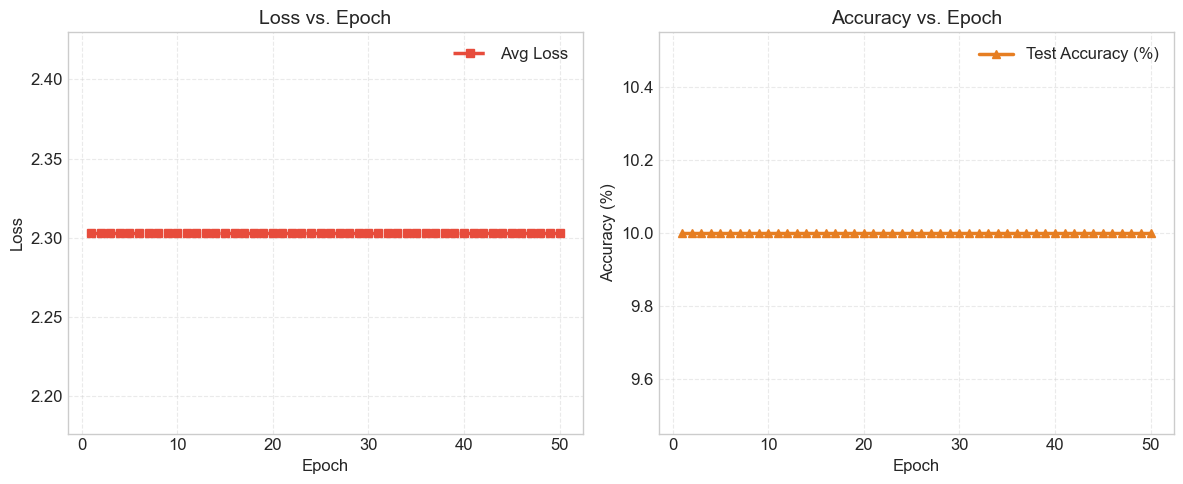

In [27]:
import re
import matplotlib.pyplot as plt

log_file = "logs_A/log.txt"

epochs = []
losses = []
accuracies = []

# 正则提取 epoch、loss、test acc
pattern = re.compile(r"Epoch (\d+), Avg Loss: ([\d\.]+), Test Acc: ([\d\.]+)%")

with open(log_file, "r") as f:
    for line in f:
        match = pattern.search(line)
        if match:
            epoch = int(match.group(1))
            loss = float(match.group(2))
            acc = float(match.group(3))
            epochs.append(epoch)
            losses.append(loss)
            accuracies.append(acc)

# 绘图
plt.figure(figsize=(12, 5))

# 子图 1：Loss 曲线
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, color='red', linewidth=2, marker='o', label="Avg Loss")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss vs. Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)

# 子图 2：Accuracy 曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, color='orange', linewidth=2, marker='o', label="Test Accuracy (%)")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.title("Accuracy vs. Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig("logs_A/training_result.png", dpi=300)
plt.show()


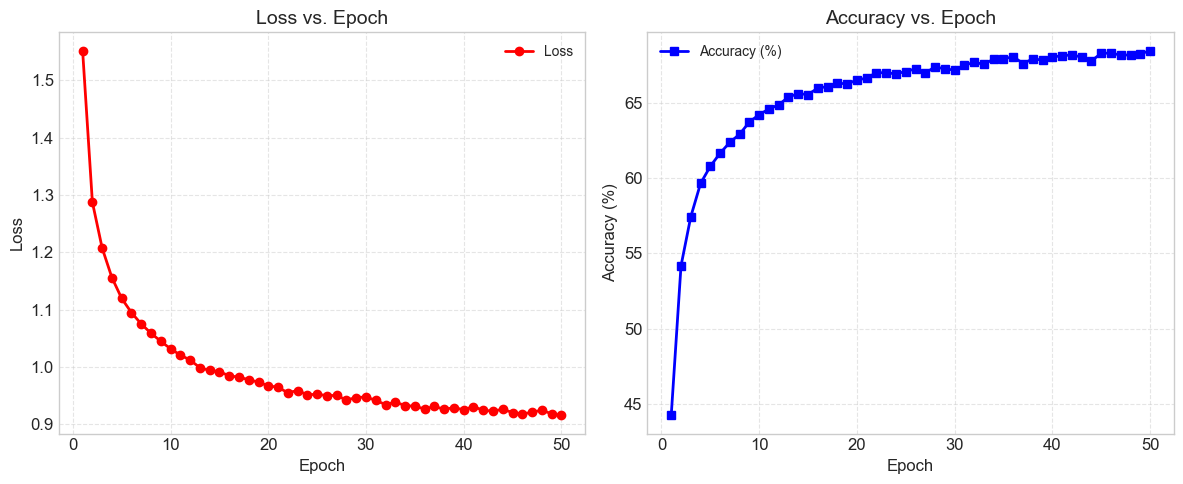

In [32]:
import re
import matplotlib.pyplot as plt

# 日志文件路径
log_file = "cnn\D\log.txt"

# 数据容器
epochs = []
losses = []
accuracies = []

# 正则表达式：匹配 Epoch、Loss 和 Acc
pattern = re.compile(r"Epoch (\d+)/\d+ \| Loss: ([\d\.]+) \| Acc: ([\d\.]+)%")

# 读取并解析日志文件
with open(log_file, "r") as f:
    for line in f:
        match = pattern.search(line)
        if match:
            epoch = int(match.group(1))
            loss = float(match.group(2))
            acc = float(match.group(3))
            epochs.append(epoch)
            losses.append(loss)
            accuracies.append(acc)

# 绘图
plt.figure(figsize=(12, 5))

# 子图1：Loss曲线
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, color='red', linewidth=2, marker='o', label="Loss")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss vs. Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)

# 子图2：Accuracy曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, color='blue', linewidth=2, marker='s', label="Accuracy (%)")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.title("Accuracy vs. Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)

# 布局 & 保存
plt.tight_layout()
plt.savefig("cnn/A/training_result.png", dpi=300)
plt.show()
